In [348]:
import fenics as fn
import numpy as np
#
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
#
from matplotlib import pyplot as plt
#
from copy import copy
from time import time

In [349]:
#label_str = 'ex02_f2_sigma3_obs_0.5_0.9'
label_str = 'ex04_f2_sigma3_obs_0.2_0.4_0.6_0.8'
aux = np.load('data/parameters_'+label_str+'.npz')

In [350]:
f_old        = aux['f_old']
f_exact_dof  = aux['f_exact_dof']
Ne           = aux['Ne']
t_vector     = aux['t_vector']
sigma_vector = aux['sigma_vector']
nu           = aux['nu']
gamma1       = aux['gamma1']
gamma2       = aux['gamma2']
K            = aux['K']
ALPHA        = aux['ALPHA']
STOP_CRI     = aux['STOP_CRI']
OBS_DOM      = aux['OBS_DOM']

In [351]:
OBS_DOM

array([0.2, 0.4, 0.6, 0.8])

In [352]:
dt = t_vector[1]
T  = t_vector[-1]
#
mesh = fn.IntervalMesh(Ne,0,1)
U1   = fn.FiniteElement("CG", mesh.ufl_cell(), 1)
U2   = fn.FiniteElement("CG", mesh.ufl_cell(), 1)
Un   = fn.FunctionSpace(mesh, U1*U2)
#
obs_1 = OBS_DOM[0]
obs_2 = OBS_DOM[1]
class Omega0(fn.SubDomain):
    def inside(self, x, on_boundary):
        return (fn.between(x[0], (obs_1, obs_2)))
#
omega0 = Omega0()
#
domains = fn.MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
omega0.mark(domains, 1)  
#
dx_obs = fn.Measure("dx", domain=mesh, subdomain_data=domains)
#
(u1, u2) = fn.TrialFunctions(Un)
(v1, v2) = fn.TestFunctions(Un)
#
ini_con = fn.Expression(('0.*x[0]','0.*x[0]'), degree=2)
u_ini = fn.Function(Un)
u_ini.interpolate(ini_con)
#
g = fn.Constant((0.,0.))
bc = fn.DirichletBC(Un, g, 'on_boundary')
#
b_forw = (u1*v1)*(fn.dx) + dt*nu*fn.dot(fn.grad(u1),fn.grad(v1))*(fn.dx) + dt*gamma1*(u2*v1)*(fn.dx) + (u2*v2)*(fn.dx) + dt*nu*fn.dot(fn.grad(u2),fn.grad(v2))*(fn.dx) + dt*gamma2*(u1*v2)*(fn.dx)
# Matrices assemble (Fenics structure)
B_forw = fn.assemble(b_forw)
# Include BC's
bc.apply(B_forw)
# Matrices to numpy array
B_forw_np = B_forw.array()
# Matrices to sparse structure
B_forw_sp = sp.csr_matrix(B_forw_np)

In [353]:
def coupled_forward(u0, rhs,t_vector):
    '''
    This function has a input the initial condition of the system
    u0 (as a Fenics function) and the rhs (f1,f2) as a list with the DoF
    at each time
    Return: the solution's DoF of the system for all times (and its derivative)
    '''
    # Initial condition
    u_ini = fn.Function(Un)
    u_ini.vector()[:] = u0.vector()[:]
    u01, u02 = u_ini.split()
    #
    sol_list = []
    sol_t_list = []
    #sol_list.append(u_ini.vector()[:])
    f = fn.Function(Un)
    f.vector()[:] = rhs
    f1, f2 = f.split()
    #loop
    #for idx in range(t_vector[1:].shape[0]):
    for idx in range(t_vector.shape[0]):    
        #print(idx)
        #
        L  = (dt*sigma(t_vector[idx])*f1*v1 + u01*v1)*(fn.dx) + (dt*sigma(t_vector[idx])*f2*v2 + u02*v2)*(fn.dx)
        rhs = fn.assemble(L)
        bc.apply(rhs)
        #
        u_sol = fn.Function(Un)
        # Sparse solver
        #fn.solve(b_forw==L,u_sol,bc)
        aux = spsolve(B_forw_sp,rhs[:])
        #
        u_sol.vector()[:] = aux
        u01, u02 = u_sol.split()
        #
        sol_list.append(u_sol.vector()[:])
    ######################################################    
    # here we added the time derivative
    sol_t_list.append((sol_list[0] - u_ini.vector()[:])/dt)
    for idx in range(1,t_vector.shape[0]):
        sol_t_list.append((sol_list[idx] - sol_list[idx-1])/dt)
    ######################################################        
    return sol_list, sol_t_list

In [354]:
f_exact = fn.Function(Un)
f_exact.vector()[:] = f_exact_dof

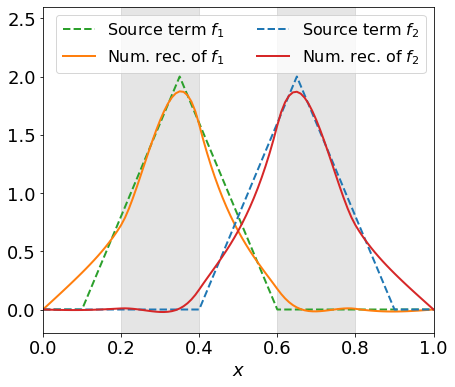

In [355]:
f1_obs, f2_obs = f_exact.split()
#
f_rec = fn.Function(Un)
f_rec.vector()[:] = f_old
f1_rec, f2_rec = f_rec.split()
#
plt.figure(figsize=(7,6))
fn.plot(f1_obs,label='Source term $f_1$',
        color='tab:green',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(f1_rec,label='Num. rec. of $f_1$',
        color='tab:orange',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
fn.plot(f2_obs,label='Source term $f_2$',
        color='tab:blue',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(f2_rec,label='Num. rec. of $f_2$',
        color='tab:red',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
#
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#
plt.xlabel(r'$x$',fontsize=18)
#
plt.xlim(0.,1.)
#plt.ylim(-1.1,1.6)
plt.ylim(-0.2,2.6)
#
plt.axvspan(OBS_DOM[0],OBS_DOM[1],color='tab:gray',alpha=0.2)
if OBS_DOM.shape[0] > 2:
    plt.axvspan(OBS_DOM[2],OBS_DOM[3],color='tab:gray',alpha=0.2)
#plt.title('SOURCE RECONS. O = (%1.1f,%1.1f)'%(OBS_DOM[0],OBS_DOM[1]),fontsize=18)
plt.legend(ncol=2,fontsize=16)
#
plt.savefig('images/source_rec_'+label_str+'.png', dpi=600, facecolor=None, edgecolor=None,
            orientation='portrait', format='png',transparent=True, 
            bbox_inches='tight', pad_inches=0.1, metadata=None)

In [356]:
error = 100*np.sqrt(fn.assemble(((f1_rec - f1_obs)**2 + (f2_rec - f2_obs)**2)*(fn.dx))/(fn.assemble(((f1_obs)**2 + (f2_obs)**2)*(fn.dx))))
print('rel error: %2.1f'%(error))

rel error: 11.7


In [357]:
T = t_vector[-1]
def sigma1(t):
    return 1. + 0.*t
############################################################################
def sigma2(t):
    t0 = 3*T/4
    aux = (1 + 2*t/t0 - (t/t0)**2)*(t < t0) + (2. + t*0)*(t >= t0)
    return aux
############################################################################
def sigma3(t):
    eps = T/10
    aux = (1 + (np.cos(4*np.pi*t/(T-eps))/2))*(t < T - eps) + 3/2*(t >= T - eps)
    return aux
############################################################################

In [358]:
#t_vector = np.linspace(0,0.5,256)
sigma1_vector = sigma1(t_vector)
sigma2_vector = sigma2(t_vector)
sigma3_vector = sigma3(t_vector)

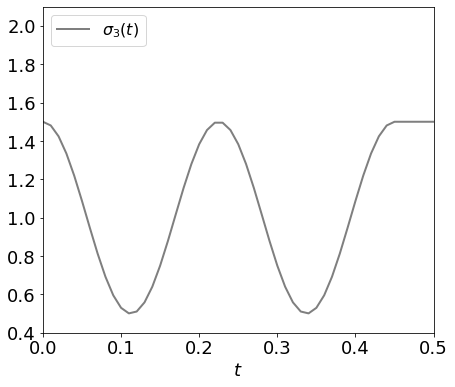

In [359]:
plt.figure(figsize=(7,6))
plt.plot(t_vector,sigma3_vector,
         color='tab:gray',
         linewidth=2.0,
         label = '$\sigma_3(t)$'
        )
#
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#
plt.xlabel(r'$t$',fontsize=18)
#
plt.xlim(0,0.5)
plt.ylim(0.4,2.1)
#
plt.legend(fontsize=16,loc='upper left')
#
#plt.savefig('images/sigma3.png', dpi=600, facecolor=None, edgecolor=None,
#            orientation='portrait', format='png',transparent=True, 
#            bbox_inches='tight', pad_inches=0.1, metadata=None)